# CIC-IDS 2017

In [1]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import PIL.Image
import torch

from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorboardX import SummaryWriter
from torchvision.transforms import ToTensor
from cic_ids_17_dataset import CIC17Dataset

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

## MachineLeanringCVE folder

These files do not contain ports. 

In [128]:
# p = Path("./data/cic-ids-2017/MachineLearningCVE").glob('**/*')
# files = [x for x in p if x.is_file()]

# dfs = [pd.read_csv(file, index_col=None) for file in files]
# df = pd.concat(dfs, axis=0)

# cols = [col.strip() for col in df.columns]
# df.columns = cols

In [129]:
# df.head()

In [130]:
# df.Label.value_counts()

In [131]:
# df.columns

## Traffic Labelling folder

In [2]:
p = Path("./data/cic-ids-2017/TrafficLabelling").glob('**/*')
files = [x for x in p if x.is_file()]

dfs = []
for file in files:
    if file.name == "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv":
        # there are 288602 empty rows at the end of Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
        # do not read those
        dfs.append(pd.read_csv(file, encoding="ISO-8859-1", nrows=170366))
    else:
        dfs.append(pd.read_csv(file, encoding="ISO-8859-1"))
    
df = pd.concat(dfs, axis=0)
df.columns = [col.strip() for col in df.columns]
df = df[df.Label != "BENIGN"]
df.reset_index(drop=True, inplace=True)

In [3]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.8-205.174.165.73-53966-444-6,192.168.10.8,53966,205.174.165.73,444,6,6/7/2017 2:19,42664070,5,6,141.0,291.0,93.0,0.0,28.200000,38.861292,267.0,0.0,48.500000,107.069603,10.125616,0.257828,4.266407e+06,1.340000e+07,42400000.0,29.0,255908.0,63977.00000,94867.03992,201415.0,609.0,42700000.0,8.532630e+06,1.890000e+07,42400000.0,595.0,0,0,0,0,112,132,0.117195,0.140634,0.0,267.0,36.000000,77.399789,5990.727273,0,0,0,1,0,0,0,0,1.0,39.272727,28.200000,48.500000,112,0,0,0,0,0,0,5,141,6,291,8192,229,4,20,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Infiltration
1,192.168.10.8-205.174.165.73-53966-444-6,192.168.10.8,53966,205.174.165.73,444,6,6/7/2017 2:19,2030,2,0,12.0,0.0,6.0,6.0,6.000000,0.000000,0.0,0.0,0.000000,0.000000,5911.330049,985.221675,2.030000e+03,0.000000e+00,2030.0,2030.0,2030.0,2030.00000,0.00000,2030.0,2030.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,40,0,985.221675,0.000000,6.0,6.0,6.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,9.000000,6.000000,0.000000,40,0,0,0,0,0,0,2,12,0,0,255,-1,1,20,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Infiltration
2,192.168.10.8-205.174.165.73-54119-444-6,192.168.10.8,54119,205.174.165.73,444,6,6/7/2017 2:28,119991834,5523,5525,2866110.0,33406.0,1274.0,0.0,518.940793,204.203530,267.0,0.0,6.046335,3.512318,24164.277710,92.072932,1.086194e+04,1.123214e+05,9432176.0,3.0,120000000.0,21729.77798,158193.16530,9432951.0,493.0,120000000.0,2.172175e+04,1.581250e+05,9432176.0,582.0,0,0,0,0,110472,110512,46.028132,46.044800,0.0,1274.0,262.423387,294.312034,86619.573440,0,0,0,1,0,0,0,0,1.0,262.447140,518.940793,6.046335,110472,0,0,0,0,0,0,5523,2866110,5525,33406,8192,3294,5522,20,997842.0,831471.3076,1585781.0,409903.0,8143987.5,1821773.648,9432176.0,6855799.0,Infiltration
3,192.168.10.8-205.174.165.73-54122-444-6,192.168.10.8,54122,205.174.165.73,444,6,6/7/2017 2:30,5005212,15,15,0.0,90.0,0.0,0.0,0.000000,0.000000,6.0,6.0,6.000000,0.000000,17.981256,5.993752,1.725935e+05,2.411964e+05,513363.0,297.0,5004692.0,357478.00000,233594.24190,513925.0,771.0,5004624.0,3.574731e+05,2.336027e+05,513927.0,832.0,0,0,0,0,460,300,2.996876,2.996876,0.0,6.0,2.903226,3.048003,9.290323,0,0,0,1,0,0,0,0,1.0,3.000000,0.000000,6.000000,460,0,0,0,0,0,0,15,0,15,90,8192,0,0,28,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Infiltration
4,192.168.10.8-205.174.165.73-54119-444-6,192.168.10.8,54119,205.174.165.73,444,6,6/7/2017 2:30,119973135,4376,4374,2321478.0,26244.0,1273.0,6.0,530.502285,262.768815,6.0,6.0,6.000000,0.000000,19568.730950,72.932995,1.371278e+04,2.045926e+04,1163091.0,1.0,120000000.0,27422.43086,23472.11964,1196394.0,95.0,120000000.0,2.743107e+04,2.257524e+04,1163557.0,52

In [4]:
missing_per_col = pd.concat([d.isna().sum().to_frame().T for d in dfs], axis=0)
missing_per_col.index = [file.stem for file in files]
missing_per_col

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Monday-WorkingHours.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Friday-WorkingHours-Morning.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tuesday-WorkingHours.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Wednesday-workingHours.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.Label.value_counts()

DoS Hulk                      231073
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Infiltration                      36
Web Attack  Sql Injection        21
Heartbleed                        11
Name: Label, dtype: int64

In [6]:
df["Source Port"].value_counts()

59328    1025
37796    1024
36448    1024
60768    1023
54368    1023
         ... 
21949       1
22608       1
23614       1
21567       1
25381       1
Name: Source Port, Length: 48883, dtype: int64

In [7]:
df["Destination Port"].value_counts()

80       383239
21         8181
22         6140
8080       1421
444         256
          ...  
2363          1
52336         1
3387          1
53875         1
4858          1
Name: Destination Port, Length: 1690, dtype: int64

In [8]:
df["Source IP"].value_counts()

172.16.0.1        555641
205.174.165.73       705
192.168.10.15        371
192.168.10.8         307
192.168.10.9         226
192.168.10.14        209
192.168.10.5         180
192.168.10.50          3
192.168.10.12          2
192.168.10.17          2
Name: Source IP, dtype: int64

In [9]:
df["Destination IP"].value_counts()

192.168.10.50     555630
205.174.165.73      1293
192.168.10.15        209
192.168.10.9         146
192.168.10.14        139
192.168.10.5         108
192.168.10.8         103
192.168.10.51         11
172.16.0.1             3
52.7.235.158           2
52.6.13.28             2
Name: Destination IP, dtype: int64

In [10]:
df.Protocol.value_counts()

6     557639
0          6
17         1
Name: Protocol, dtype: int64

### Handle missing vals in Flow Bytes/s

This happens for 949 rows, all DoS Hulk attacks. Looks like all packets are empty where `Flow Bytes/s` is NaN. Replace with 0.0. 

In [11]:
missing_flow_bytes = df[df["Flow Bytes/s"].isna()]
missing_flow_bytes.describe()

/Users/thomas/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,949.000000,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,0.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.000000,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0
mean,46652.678609,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,259.696523,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,8320.973736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.344556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,32782.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,251.000000,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,38870.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,251.000000,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,46868.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,251.000000,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,53784.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,274.000000,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,60992.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [12]:
missing_flow_bytes.Label.value_counts()

DoS Hulk    949
Name: Label, dtype: int64

In [13]:
df["Flow Bytes/s"] = df["Flow Bytes/s"].fillna(value=0.0)

### Label encoding

In [14]:
label_encoder = LabelEncoder()
df.Label = label_encoder.fit_transform(df.Label)
df.Label.value_counts(), label_encoder.classes_, label_encoder.inverse_transform([1, 2, 3])

(3     231073
 9     158930
 1     128027
 2      10293
 6       7938
 10      5897
 5       5796
 4       5499
 0       1966
 11      1507
 13       652
 8         36
 12        21
 7         11
 Name: Label, dtype: int64,
 array(['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
        'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration',
        'PortScan', 'SSH-Patator', 'Web Attack \x96 Brute Force',
        'Web Attack \x96 Sql Injection', 'Web Attack \x96 XSS'],
       dtype=object),
 array(['DDoS', 'DoS GoldenEye', 'DoS Hulk'], dtype=object))

### Drop cols

We don't need to generate: 
- `Flow ID`
- `Source IP`
- `Destination IP`
- `Protocol IP`
- `Timestamp`

In [15]:
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Protocol", "Timestamp"]
df = df.drop(drop_cols, axis=1)

In [16]:
df.dtypes.to_frame().T

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64


### Handle `inf` values in `Flow Bytes/s` and `Flow Packets/s`
`Flow Bytes/s` and `Flow Packets/s` contain `inf` values. This is problematic for scaling and in general. 

For all ~1000 rows where this is the case, `Flow Duration` is 0. Possibly invalid Flows, so we remove them. 



In [17]:
np.isinf(df).any().to_frame().T

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [18]:
# flow duration is 0 for all 
inf_rows = df.index[np.isinf(df).any(1)]
df_inf = df.iloc[inf_rows]
df_inf

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
73,51956,8080,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,256,237,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
165,8080,52235,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,245,256,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
621,8080,2846,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,237,16393,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
716,52727,8080,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,256,237,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
729,52728,8080,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,256,237,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541278,52282,80,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
541331,52518,80,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
541369,52662,80,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
541401,52840,80,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,64,0,

In [19]:
# probably not problematic if we drop the rows. 
df_inf.Label.value_counts()

3    949
9    126
0     10
6      3
1      2
Name: Label, dtype: int64

In [20]:
df = df[np.isfinite(df).all(1)]

### Min-Max scale numeric columns

In [21]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop("Label", axis=1))

### Feature distributions

To create the distribution plots we use `seaborn`. There are two functions `.displot()` and `.histplot()`.
Plotting the KDE is realtively expsensive, as can be seen in the plots below (1s vs. 3s). 

In [22]:
df.describe()

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,556556.000000,556556.000000,5.565560e+05,556556.000000,556556.000000,5.565560e+05,5.565560e+05,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,556556.000000,556556.0,556556.0,556556.0,556556.000000,556556.000000,5.565560e+05,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,5.565560e+05,556556.000000,556556.000000,556556.0,556556.000000,556556.000000,556556.000000,556556.0,556556.0,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,556556.0,556556.0,556556.0,556556.0,556556.0,556556.0,556556.000000,5.565560e+05,556556.000000,5.565560e+05,556556.000000,556556.000000,556556.000000,556556.000000,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,556556.000000
mean,46869.805996,2578.858081,2.937422e+07,4.094876,3.287459,1.981773e+02,5.223815e+03,114.942177,2.087483,24.848931,45.984842,2809.756370,1.864871,899.379642,1202.652932,3.158834e+05,9.564908e+04,2.892205e+06,8.405503e+06,2.843157e+07,2.233378e+05,2.914620e+07,5.514674e+06,1.151668e+07,2.834528e+07,5.415419e+05,8.811593e+06,1.905644e+06,3.503289e+06,8.524196e+06,3.476416e+05,0.012062,0.0,0.0,0.0,119.077908,96.238625,8.618289e+04,9466.190468,0.988612,2815.219807,428.162249,896.571556,1.999662e+06,0.105943,0.012062,0.0,0.462051,0.432772,0.008668,0.0,0.0,0.613121,469.640378,24.848931,899.379642,119.077908,0.0,0.0,0.0,0.0,0.0,0.0,4.094876,1.981773e+02,3.287459,5.223815e+03,7400.775284,297.411107,1.576889,27.412889,1.027633e+05,1.939657e+04,1.164495e+05,8.872371e+04,2.699749e+07,1.499228e+06,2.814479e+07,2.592600e+07,4.404669
std,10665.438617,8281.191787,4.229991e+07,18.475176,16.610726,6.778826e+03,3.379721e+04,217.935178,42.092699,65.914081,75.824392,3448.347784,14.359901,1047.098848,1529.813281,1.359428e+07,3.075299e+05,5.563720e+06,1.229449e+07,4.150648e+07,3.838665e+06,4.233110e+07,9.928093e+06,1.729540e+07,4.156235e+07,6.737672e+06,2.688660e+07,7.449840e+06,1.116808e+07,2.652787e+07,5.113572e+06,0.109161,0.0,0.0,0.0,482.749184,408.195484,3.022790e+05,38817.645669,8.148357,3447.031663,500.323074,1093.596586,3.095643e+06,0.307764,0.109161,0.0,0.498558,0.495460,0.092696,0.0,0.0,0.592593,553.210811,65.914081,1047.098848,482.749184,0.0,0.0,0.0,0.0,0.0,0.0,18.475176,6.778826e+03,16.610726,3.379721e+04,11654.885078,2291.768309,13.872833,7.326114,6.890650e+05,3.277816e+05,7.980474e+05,6.477047e+05,4.077012e+07,8.389912e+

In [23]:
df.nunique().to_frame().T

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,48883,1686,310349,72,92,1847,213,600,21,4824,10945,88,10,269,632,310115,318710,305985,155540,129959,4967,78399,100859,96036,78485,8244,139700,166910,207385,137083,6213,2,1,1,1,199,139,315787,259019,7,366,8828,61385,59534,2,2,1,2,2,2,1,1,7,8856,4824,269,199,1,1,1,1,1,1,72,1847,92,213,70,74,57,7,25808,2081,25706,23795,27595,622,27467,38684,14


In [24]:
src_ports = df_scaled[:, 0]
src_ports_fake = np.random.rand(500)

CPU times: user 1.64 s, sys: 198 ms, total: 1.83 s
Wall time: 3.83 s


Text(0.5, 1.0, 'Population vs. generated distribution: FEATURE_NAME')

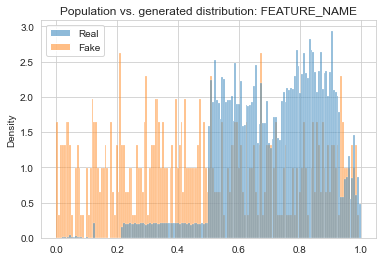

In [25]:
%%time
sns.histplot({"Real": src_ports, "Fake": src_ports_fake}, stat="density", element="bars", common_norm=False, kde=False, alpha=0.5)
plt.title("Population vs. generated distribution: FEATURE_NAME")

CPU times: user 1.2 s, sys: 145 ms, total: 1.34 s
Wall time: 3.22 s


Text(0.5, 1.0, 'Population vs. generated distribution: FEATURE_NAME')

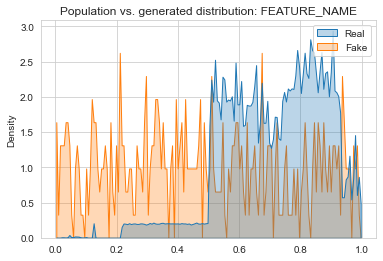

In [26]:
%%time
sns.histplot({"Real": src_ports, "Fake": src_ports_fake}, stat="density", element="poly", common_norm=False, kde=False, alpha=0.3)
plt.title("Population vs. generated distribution: FEATURE_NAME")

CPU times: user 3.28 s, sys: 183 ms, total: 3.46 s
Wall time: 4.53 s


Text(0.5, 1.0, 'Population vs. generated distribution: FEATURE_NAME')

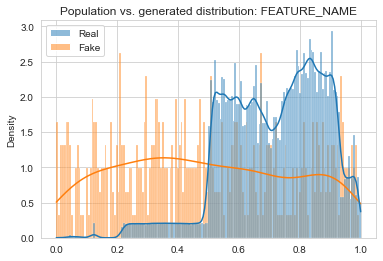

In [27]:
%%time
sns.histplot({"Real": src_ports, "Fake": src_ports_fake}, stat="density", common_norm=False, kde=True)
plt.title("Population vs. generated distribution: FEATURE_NAME")

CPU times: user 2.83 s, sys: 132 ms, total: 2.96 s
Wall time: 2.81 s


Text(0.5, 1.0, 'Population vs. generated distribution: FEATURE_NAME')

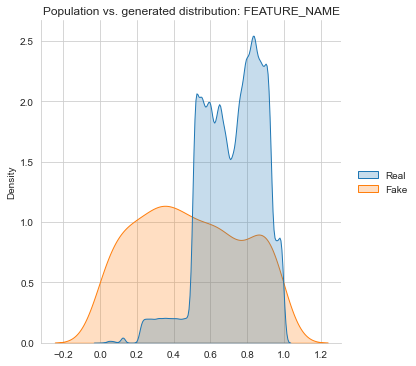

In [28]:
%%time
sns.displot({"Real": src_ports, "Fake": src_ports_fake}, kind="kde", common_norm=False, fill=True)
plt.title("Population vs. generated distribution: FEATURE_NAME")

### TensorBoard distribution logging

For evaluation during training, we can compare the distributions of the generated features with the actual distributions. 
Therefore, we write the relevant plots to TensorBoard.

However, it is not useful to generate the plots for every feature. Therefore, we select a few representative ones:
- `Source Port`
- `Destination Port` 
- `Flow Duration`
- `Flow Packets/s`
- `Fwd Packets/s`
- `Bwd Packets/s`
- `Average Packet Size`
- `Idle Mean`

We will have to create the plots many times. Therefore, using the whole train dataset for the ground truth distribution is slow. However, we can take the test dataset instead to avoid overhead. For example, creating the same plot as before with `Source Port` using the test dataset take 7 µs, instead of 3 seconds before. 

The distributions of train and test dataset should be (~) same anyway. To check this we plot the train against the testing distribution for a few features. 


In [29]:
train_dataset = CIC17Dataset("./data/cic-ids-2017_splits/seed_0/X_train_scaled.pt",
                             "./data/cic-ids-2017_splits/seed_0/y_train_scaled.pt")
test_dataset = CIC17Dataset("./data/cic-ids-2017_splits/seed_0/X_test_scaled.pt",
                            "./data/cic-ids-2017_splits/seed_0/y_test_scaled.pt")
column_names = torch.load("./data/cic-ids-2017_splits/seed_0/column_names.pt")
col_to_idx = {col: i for i, col in enumerate(column_names)}

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 33.9 µs


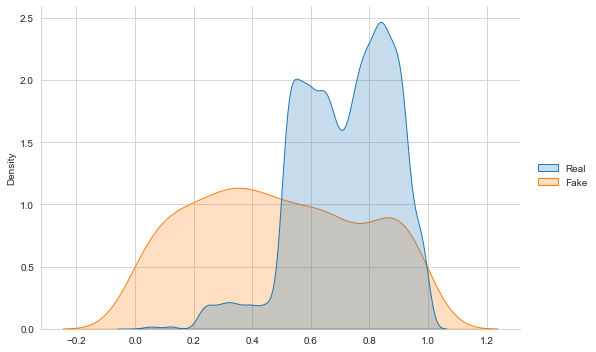

In [36]:
%time 
src_port_idx = col_to_idx["Source Port"]
sns.displot({"Real": test_dataset.X[:, src_port_idx], "Fake": src_ports_fake}, kind="kde", common_norm=False, fill=True, height=5, aspect=1.5)

CPU times: user 27.7 s, sys: 1.73 s, total: 29.5 s
Wall time: 39.3 s


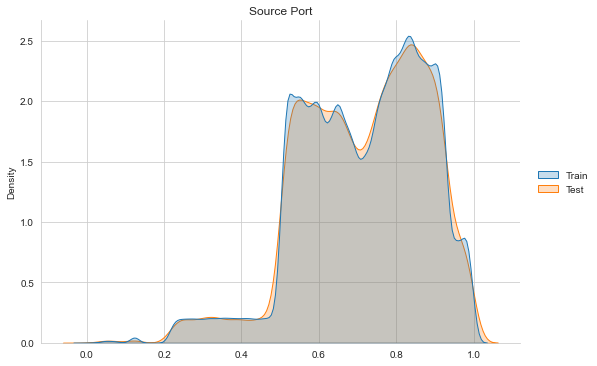

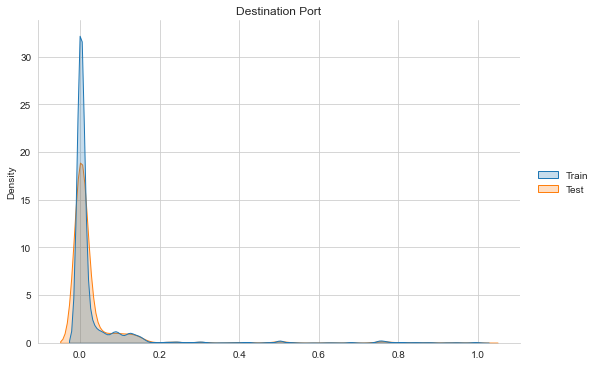

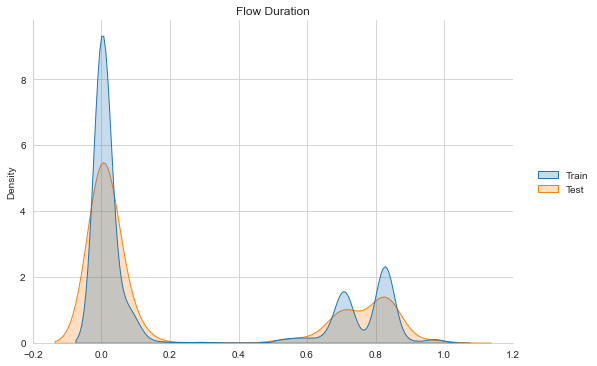

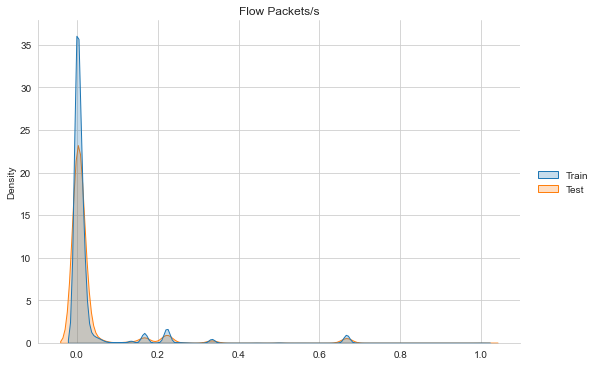

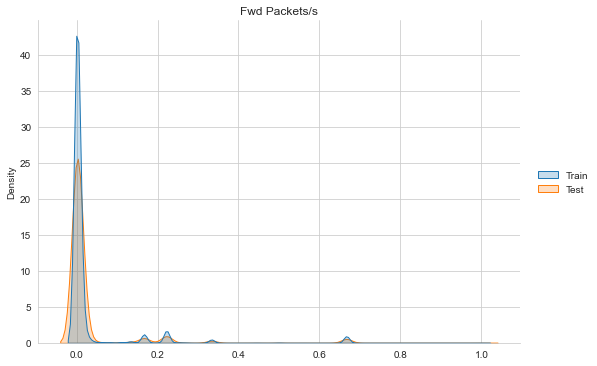

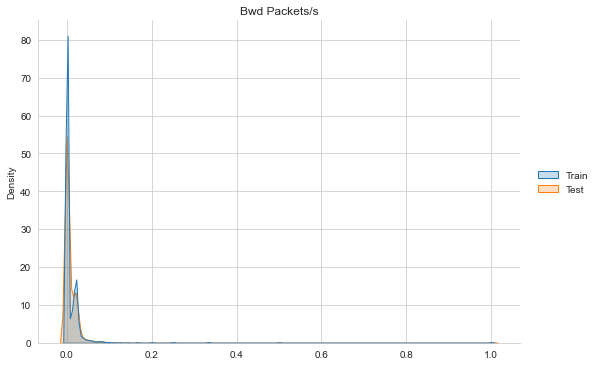

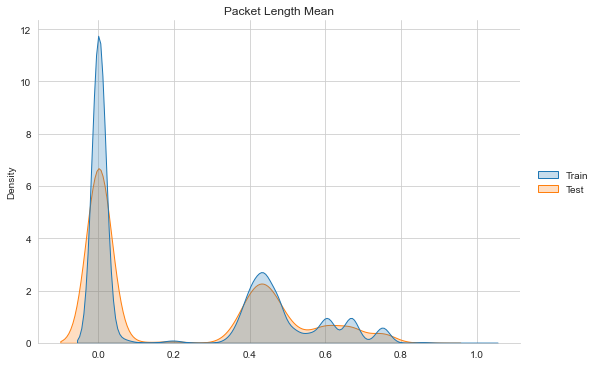

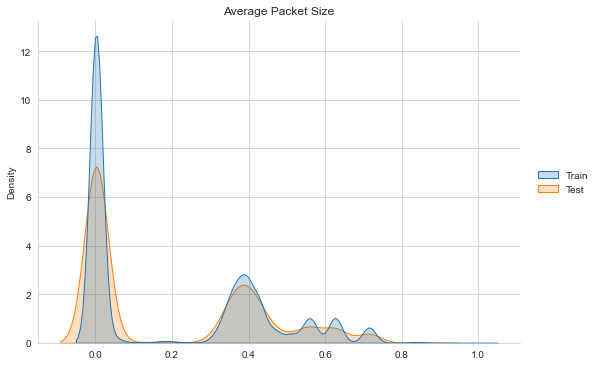

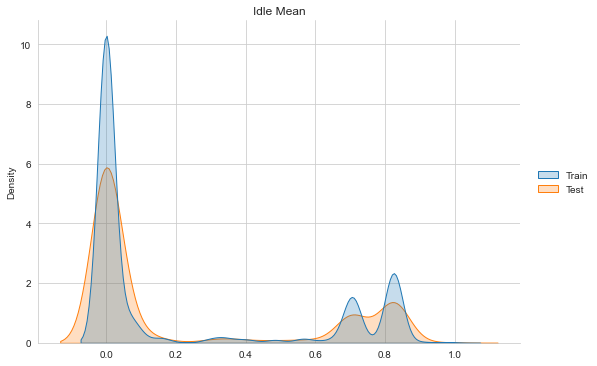

In [35]:
%%time
cols = ["Source Port", "Destination Port", "Flow Duration", "Flow Packets/s", "Fwd Packets/s", "Bwd Packets/s", "Packet Length Mean", "Average Packet Size", "Idle Mean"]
for col in cols:
    idx = col_to_idx[col]
    sns.displot({"Train": train_dataset.X[:, idx], "Test": test_dataset.X[:, idx]}, kind="kde", common_norm=False, fill=True, height=5, aspect=1.5)
    plt.title(col)

In [ ]:
%%time

def make_image(real, fake, feature_name):
    """
    Images cannot be written to TensorBoard directly. Easiest way is to write them to IOBuffer, then convert to PyTorch tensor. 
    
    """
    sns.displot({"Real": real, "Fake": fake}, kind="kde", common_norm=False, fill=True, height=5, aspect=1.5)
    plt.title(f"Population vs. generated distribution: {feature_name}")
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close("all")
    buf.seek(0)
    image = PIL.Image.open(buf)
    image = ToTensor()(image)
    return image

feature_name = "Src Ports"
src_ports = test_dataset.X[:, 0]
writer = SummaryWriter(log_dir="./test/test4")

for i in tqdm(range(10)):
    src_ports_fake = np.random.rand(500)
    image = make_image(src_ports, src_ports_fake, feature_name)
    writer.add_image(feature_name, image, i)
    writer.add_image(feature_name + "_test", image, i)